# Sentence Embedding & K-Means

In [31]:
import preprocess
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
data = preprocess.read_encrypted_data()
df = preprocess.reformat_data(data)

In [5]:
# Call_Created_Date	
# Event_Anonymizer	
# Call_Class	
# Call_Subclass	
# Initial_Dispatched_Event_Type_Code_Desc	
# Initial_Dispatched_Subtype_Code_Desc	
# Initial_Dispatched_Priority	
# Public_Generated_Event_Flag	
# Event_Attended_Flag	
# Event_Type_Changed_Flag	
# Event_Subtype_Changed_Flag	
# Event_Priority_Changed_Flag	
# Grouped_Event_Type_Code_Desc	
# Grouped_Event_Subtype_Code_Desc	
# Priority

In [6]:
# Load sentence transformers
model = SentenceTransformer("sentence-transformers/LaBSE")
embeddings = model.encode(['I want to have some chinese food.', 'I love Japanese food.'])
embeddings.shape

(2, 768)

In [13]:
# Function to compile text from the dataframe row
def compile_text(x):
    text = (
        f"Description of the behaviour or criminal offense (Occurrence_Type): {x['Occurrence_Type']} " 
        f"Broadest level categorization of Occurrence_Type: {x['Occurrence_Type_UCR_Category']} " 
        f"Second level categorization of Occurrence_Type: {x['Occurrence_Report_Category']} "
        f"The priority level assigned to the call by the ECO (911 call taker): {x['Priority']} "
        f"The call was initiated by a member of the public: {x['Public_Generated_Event_Flag']} " 
        f"Flag that indicates the call was attended in person by an officer: {x['Event_Attended_Flag']} "
        f"The log of the event: {x['Event_Remarks_Text']}" 
    )
    return text

# Function to output embeddings
def output_embedding(txt):
    embd = model.encode(txt)
    return embd

# Apply the preprocessing function to the dataframe
df['combined_text_embedding'] = df.apply(lambda x: output_embedding(compile_text(x)), axis=1)


In [17]:
# Convert the embeddings to a suitable format for clustering
embeddings = df['combined_text_embedding'].tolist()

embeddings_array = np.array(embeddings)

# Use KMeans with cosine distance
kmeans = KMeans(n_clusters=30, random_state=0)

# KMeans doesn't directly support cosine similarity, so we convert cosine distance to euclidean distance
cosine_sim_matrix = 1 - pairwise_distances(embeddings_array, metric='cosine')
kmeans.fit(cosine_sim_matrix)

# Assign clusters back to the dataframe
df['cluster'] = kmeans.labels_

print(df[['combined_text_embedding', 'cluster']])

/Users/haydenchiu/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                                combined_text_embedding  cluster
0     [0.0076662553, -0.020088516, -0.024753636, 0.0...       11
1     [0.021330677, 0.0019543592, -0.0057331966, 0.0...       19
2     [-0.026894163, -0.016634393, -0.035245452, -0....       28
3     [-0.031451143, 0.015520244, -0.031519383, -0.0...        2
4     [-0.020878322, -0.0031696116, -0.013080185, 0....       29
...                                                 ...      ...
9746  [-0.018510398, -0.016472813, -0.038595024, 0.0...       21
9747  [-0.023030989, -0.04818049, -0.01940878, -0.00...        4
9748  [-0.028092356, 0.012531011, -0.048224226, 0.02...        5
9749  [-0.032723602, -0.005803833, -0.036100466, 0.0...        9
9750  [-0.01931175, -0.016785521, -0.022748863, -0.0...        8

[9751 rows x 2 columns]


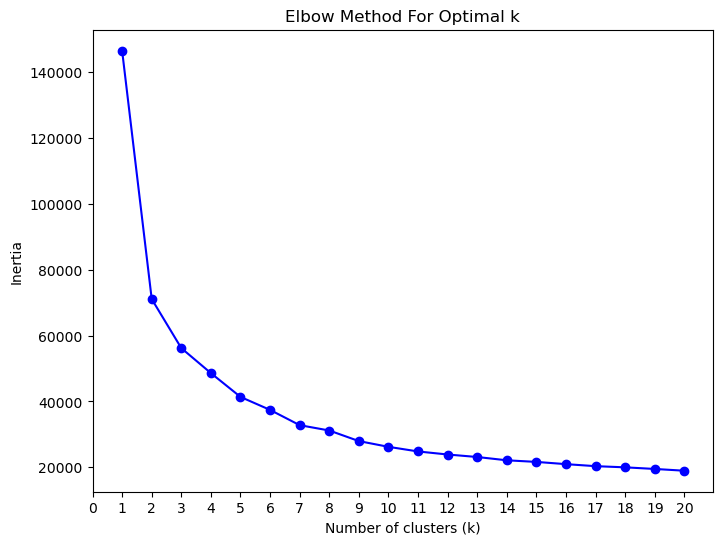

In [21]:
# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    # KMeans doesn't directly support cosine similarity, so we convert cosine distance to euclidean distance
    cosine_sim_matrix = 1 - pairwise_distances(embeddings_array, metric='cosine')
    kmeans.fit(cosine_sim_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

# Let's say we have 9 clusters

In [22]:
kmeans = KMeans(n_clusters=9, random_state=0)

kmeans.fit(cosine_sim_matrix)

# Assign clusters back to the dataframe
df['cluster'] = kmeans.labels_

print(df[['Event_Remarks_Text', 'cluster']])

/Users/haydenchiu/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                     Event_Remarks_Text  cluster
0                    WALKTHRU\nSPECIAL ADDRESS COMMENT:        0
1     WALKTHRU\n1825 [Redacted]\n1458 IT; ADULT FML ...        5
2     [Redacted] WIR\n[Redacted] SITE W5426\n4637 [R...        3
3     [Redacted] MOB H\nAccept Advised Event:\nSPECI...        6
4     [Redacted] MOBIL\nProblem: OUTSIDE OF [Redacte...        4
...                                                 ...      ...
9746  CO SECURITY REPORTING A 1041 ON NON EMERG BUT ...        2
9747  FAMILY MEMBER HAS PASSED, ALL THE PAPERWORK WI...        2
9748  FREEDOM [Redacted]\nAccept Advised Event:\n[Re...        3
9749  P915 (CAD) NO TIMERS, TAKING LRT THROUGHOUT 3,...        7
9750  CO SAID HER SON WENT OUT AROUND 2100 HRS, 2023...        6

[9751 rows x 2 columns]


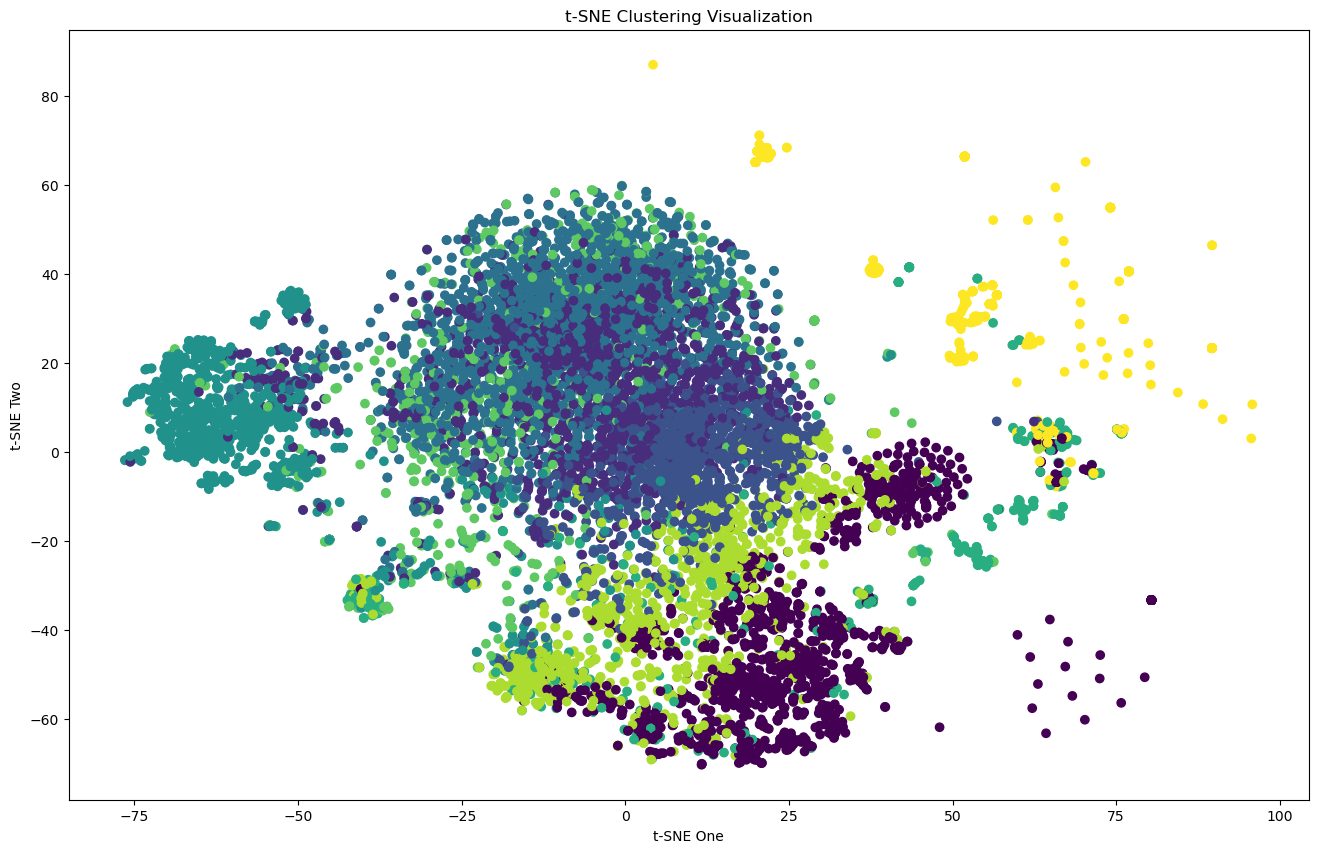

In [32]:
# Visualization using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(embeddings_array)
df['tsne-one'] = tsne_result[:,0]
df['tsne-two'] = tsne_result[:,1]

plt.figure(figsize=(16,10))
plt.scatter(df['tsne-one'], df['tsne-two'], c=df['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE Clustering Visualization')
plt.show()